In [50]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import wkw

import torch
from torch.utils import data
from torch.utils.tensorboard import SummaryWriter
# imports from genem package
from genem.util import viewData,gpu
# Get the empty gpu
gpu.get_empty_gpu()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 1 process(es) running on GPU
Found the following processes: 
GPU ID: 0, PID: 257592, Type: b'C', Pname: b'python', Mem: b'15511MiB'
Empty GPUs: [1]
Assigned GPU 1


In [51]:
# Log directory
log_root = './__logs__/'

In [52]:
# The mag 1 of this dataset points to mag 8-8-1 in the original dataset
path_wkw = '/tmpscratch/webknossos/Connectomics_Department/2018-11-13_scMS109_1to7199_v01_l4_06_24_fixed_mag8/color/1/'
# Open the dataset for reading
dataset = wkw.Dataset.open(path_wkw)
# Bounding box taken out of the datasource.json
dataset_bbox = 19500, 15250, 9, 11250, 11250,7168
# Read a single plane
emData = dataset.read([19500, 15250, 9], [302, 302, 7000])

In [53]:
# View the data
viewData.ImageSliceViewer3D(emData.squeeze(0))

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [54]:
# Transform data so that the third dimension would be the first so that each slice would be an individual sample
correctedDimforPytorch = emData.squeeze(0).transpose((2,0,1))
viewData.ImageSliceViewer3D(correctedDimforPytorch)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [78]:
# Normalize data
data_floatType = correctedDimforPytorch.astype(np.single)
data_normalized = np.asarray((data_floatType - data_floatType.mean())/data_floatType.std())

In [83]:
data_expanded = np.expand_dims(data_normalized,1)
data_expanded.shape,data_expanded.mean(),data_expanded.std()

((7000, 1, 302, 302), 8.6692046e-07, 0.99999857)

In [84]:
viewData.ImageSliceViewer3D(data_normalized)

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [91]:
torch.from_numpy(data_expanded).shape

torch.Size([7000, 1, 302, 302])

In [105]:
# create pytorch data loader from the numpy array
dataSet = data.TensorDataset(torch.from_numpy(data_expanded))
trainloader = data.DataLoader(dataSet, batch_size=32, shuffle=True, num_workers=2)

In [106]:
for i,curTensor in enumerate(trainloader):
    print(curTensor[0].shape)

torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size([32, 1, 302, 302])
torch.Size

In [107]:
# Code copied from the autoencoder script
def get_conv_pad(input_size, kernel_size, stride):
    padding = np.ceil(((stride-1)*input_size-stride+kernel_size)/2).astype(int)
    return padding

def data2fig_subplot(inputs, outputs, idx):
    fig, axs = plt.subplots(1, 2, figsize=(16,12))
    input_cpu = inputs[idx].data.cpu()
    img_input = input_cpu.numpy().squeeze()
    axs[0].imshow(img_input, cmap='gray')
    output_cpu = outputs[idx].data.cpu()
    img_output = output_cpu.numpy().squeeze()
    axs[1].imshow(img_output, cmap='gray')
    return fig

class Encoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, input_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.input_size = input_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.encoding_conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, n_fmaps, kernel_size, stride),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
    
        self.encoding_conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*2, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(n_fmaps*4, n_fmaps*8, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*8),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        
        self.encoding_fc = torch.nn.Sequential(
            torch.nn.Linear(17**2*n_fmaps*8, n_latent),
            torch.nn.ReLU())
        
    def forward(self, x):
        
        x = self.encoding_conv1(x)
        x = self.encoding_conv2(x)
        x = self.encoding_conv3(x)
        x = self.encoding_conv4(x)
        x = self.encoding_fc(x.reshape((-1, 1, 17**2*n_fmaps*8)))
        
        return x

class Decoder_4_sampling_bn(torch.nn.Module):
    
    def __init__(self, output_size, kernel_size, stride, n_fmaps, n_latent):
        super().__init__()
        
        self.output_size = output_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.n_fmaps = n_fmaps
        self.n_latent = n_latent
        
        self.decoding_fc = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 17**2*n_fmaps*8),
            torch.nn.ReLU())
        
        self.decoding_convt1 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*8, n_fmaps*4, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*4),
            torch.nn.ReLU())
        
        self.decoding_convt2 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*4, n_fmaps*2, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps*2),
            torch.nn.ReLU())

        self.decoding_convt3 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps*2, n_fmaps, kernel_size, stride),
            torch.nn.BatchNorm2d(n_fmaps),
            torch.nn.ReLU())
        
        self.decoding_convt4 = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='nearest'),
            torch.nn.ConvTranspose2d(n_fmaps, 1, kernel_size, stride))
        
    def forward(self, x):
        
        x = self.decoding_fc(x)
        x = self.decoding_convt1(x.reshape((-1, n_fmaps*8, 17, 17)))
        x = self.decoding_convt2(x)
        x = self.decoding_convt3(x)
        x = self.decoding_convt4(x)
        
        return x

class AE(torch.nn.Module):
    
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [108]:
input_size=302
output_size=input_size
kernel_size=3
stride=1
n_fmaps=8
n_latent=5000
net = AE(
    Encoder_4_sampling_bn(input_size, kernel_size, stride, n_fmaps, n_latent), 
    Decoder_4_sampling_bn(output_size, kernel_size, stride, n_fmaps, n_latent))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.02, momentum=0.9)
# Copy network to cuda
#net = net.cuda();

In [ ]:
writer = SummaryWriter(log_root)
writer_int = 5
#epoch_writer_int = 5
n_epoch = 50000
it = 0
for epoch in range(n_epoch):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, curData in enumerate(trainloader):
        it += 1

        inputs = curData[0]
        #inputs = inputs.cuda();
        labels = inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics 
        running_loss += loss.item()
        
        if (i+1) % writer_int == 0:
            avg_loss = running_loss / writer_int
            #if (epoch+1) % epoch_writer_int == 0:
            print('it: {} (epoch: {}, batch: {}), running loss: {:0.3f}'.format(it, epoch, i+1, avg_loss))

            writer.add_scalar('loss', loss.item(), it)
            writer.add_scalar('avg_loss', avg_loss, it)
            writer.add_figure('inputs', data2fig_subplot(inputs, outputs, 0), it)

            running_loss = 0.0

it: 5 (epoch: 0, batch: 5), running loss: 1.643
it: 10 (epoch: 0, batch: 10), running loss: 1.171
it: 15 (epoch: 0, batch: 15), running loss: 1.052
it: 20 (epoch: 0, batch: 20), running loss: 1.060


In [72]:
print(len(trainloader))

70


In [68]:
enumerate(trainloader)

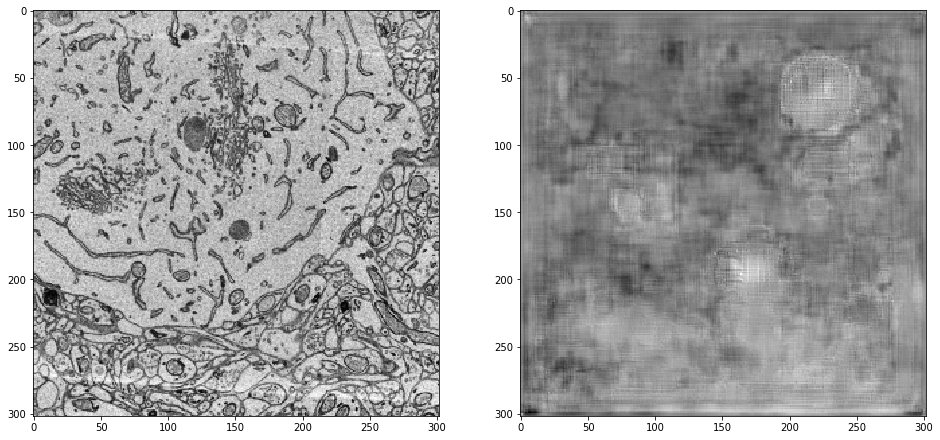

In [104]:
data2fig_subplot(inputs, outputs, 9);